In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True
                    
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

SyntaxError: invalid syntax (705249800.py, line 9)

In [12]:
# Get data
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset = raw_dataset.copy()
dataset = dataset.dropna()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [13]:
# dummies 
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [14]:
# split training and testing 
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


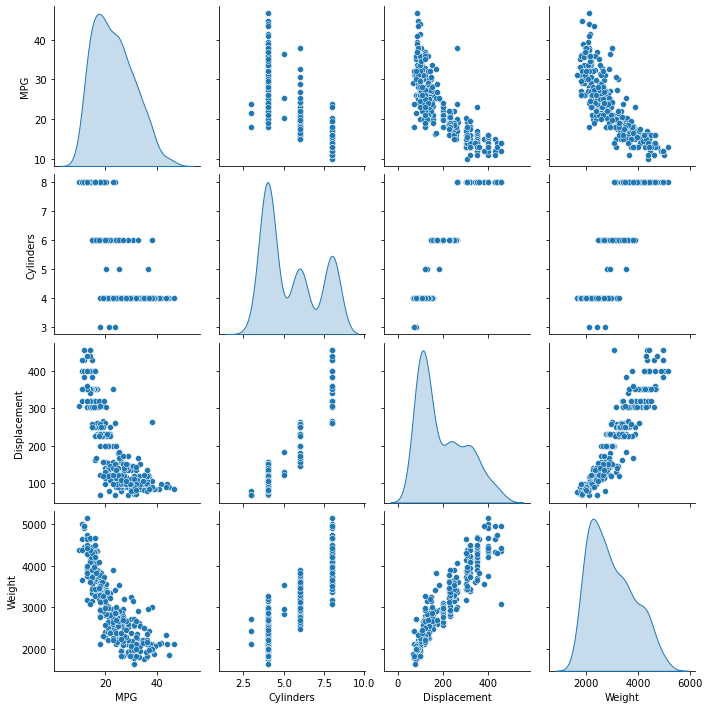

In [18]:
# inspect data
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')
train_dataset.describe().transpose()


In [21]:
# Get label (what we predicting)
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

# describe data 
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


In [36]:
# Normlization layer 
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

first = np.array(train_features[:3])

# Example of normalization
with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]
 [   4.   140.    88.  2890.    17.3   79.     0.     0.     1. ]
 [   8.   350.   160.  4456.    13.5   72.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]
 [-0.87 -0.53 -0.44 -0.12  0.63  0.85 -0.47 -0.5   0.78]
 [ 1.49  1.48  1.45  1.74 -0.74 -1.06 -0.47 -0.5   0.78]]


In [57]:
# Regression on just horsepower
horsepower = np.array(train_features['Horsepower'])
horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

# Model 
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

# Initial test without training
print(horsepower_model.predict(horsepower[:10]))

# compile 
horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_9 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________
[[ 1.114]
 [ 0.629]
 [-2.057]
 [ 1.562]
 [ 1.413]
 [ 0.555]
 [ 1.674]
 [ 1.413]
 [ 0.368]
 [ 0.629]]


Epoch 1/100
8/8 [==============================] - 0s 6ms/step - loss: 3.8121 - val_loss: 4.1767
Epoch 2/100
8/8 [==============================] - 0s 3ms/step - loss: 3.8109 - val_loss: 4.2163
Epoch 3/100
8/8 [==============================] - 0s 4ms/step - loss: 3.8061 - val_loss: 4.2092
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 3.8040 - val_loss: 4.1652
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 3.8054 - val_loss: 4.1387
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 3.8074 - val_loss: 4.1638
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 3.8104 - val_loss: 4.2056
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 3.8041 - val_loss: 4.1692
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 3.8097 - val_loss: 4.1550
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 3.8043 - val_loss: 4.1875
Epoch 11/100
8/8 [===========

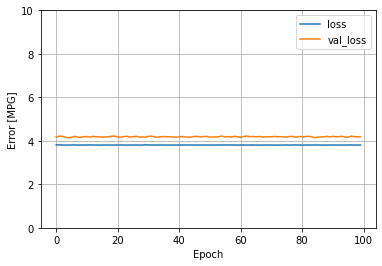

In [51]:
# Train
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

# Visualize
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

plot_loss(history)

test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels)

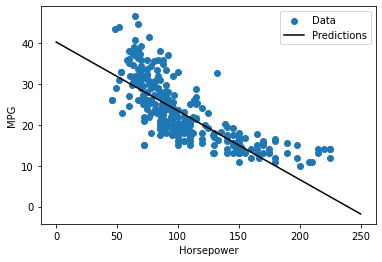

In [56]:
# View linear model 
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

def plot_horsepower(x, y):
    plt.scatter(train_features['Horsepower'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

plot_horsepower(x, y)

In [64]:
# Multiple inputs for regression
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

# Untrained linear model 
print(linear_model.predict(train_features[:10]))

# compile 
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

# Train 
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

[[ 0.106]
 [ 0.407]
 [-2.51 ]
 [ 0.68 ]
 [ 2.988]
 [ 0.082]
 [ 3.366]
 [ 1.553]
 [-0.246]
 [ 2.615]]
Epoch 1/100
8/8 [==============================] - 0s 14ms/step - loss: 22.9107 - val_loss: 23.0203
Epoch 2/100
8/8 [==============================] - 0s 3ms/step - loss: 22.0802 - val_loss: 22.3587
Epoch 3/100
8/8 [==============================] - 0s 4ms/step - loss: 21.2355 - val_loss: 21.6101
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 20.3990 - val_loss: 20.8825
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 19.5681 - val_loss: 20.1452
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 18.7848 - val_loss: 19.4524
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 17.9319 - val_loss: 18.7217
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 17.1237 - val_loss: 18.0141
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 16.2910 - val_loss: 17.2730
Epoch 1

3/3 [==============================] - 0s 1ms/step - loss: 2.5375


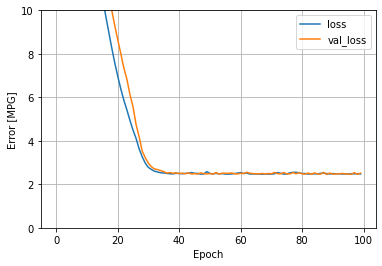

In [66]:
# View training data
plot_loss(history)

# Save evaluation
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=1)

In [67]:
# Regression with DNN ! 
def build_and_compile_model(norm):
    model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [71]:
# Single input DNN 
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)
dnn_horsepower_model.summary()

# train
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=1, epochs=100)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_9 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                128       
_________________________________________________________________
dense_21 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________
Epoch 1/100
8/8 [==============================] - 0s 15ms/step - loss: 23.1417 - val_loss: 23.5521
Epoch 2/100
8/8 [==============================] - 0s 3ms/step - loss: 22.9525 - val_loss: 23.3470
Epoch 3/100
8/8 [==============================] -

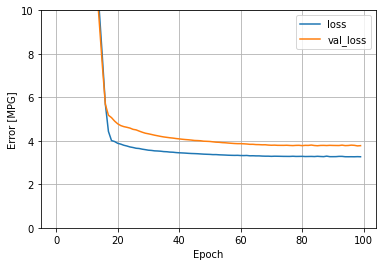

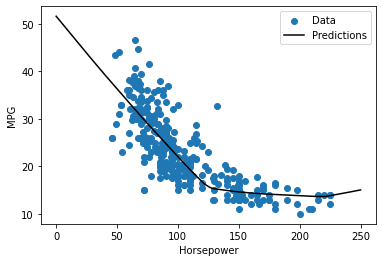

In [75]:
# Plot history 
plot_loss(history)
plt.show() 

# view the regression 
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)
plot_horsepower(x, y)
plt.show()

In [79]:
# Muliple inputs DNN ! 
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

# Train 
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=1, epochs=100)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_4 (Normalizati (None, 9)                 19        
_________________________________________________________________
dense_26 (Dense)             (None, 64)                640       
_________________________________________________________________
dense_27 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________
Epoch 1/100
8/8 [==============================] - 0s 16ms/step - loss: 22.7475 - val_loss: 22.8289
Epoch 2/100
8/8 [==============================] - 0s 3ms/step - loss: 22.1121 - val_loss: 22.0735
Epoch 3/100
8/8 [==============================] 

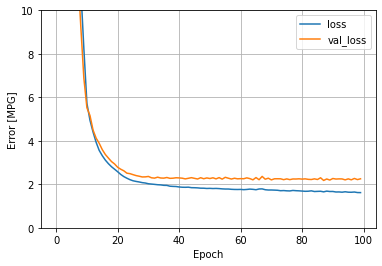

3/3 [==============================] - 0s 1ms/step - loss: 1.7159


In [82]:
# Plot history 
plot_loss(history)
plt.show()

# Collect results
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=1)
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=1)

In [86]:
# performance comparison 
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.634116
linear_model,2.537475
dnn_model,1.715910
dnn_horsepower_model,2.925020


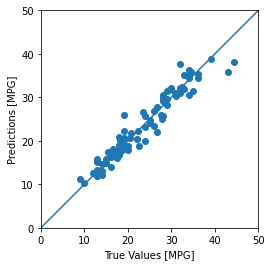

In [92]:
# Make predictions 
test_predictions = dnn_model.predict(test_features).flatten()

# graph 
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.show()

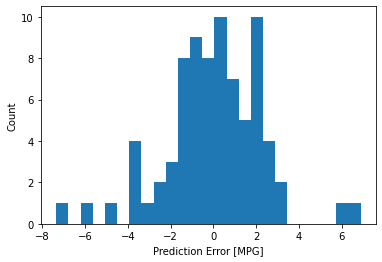

In [93]:
# Error distribution 
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

In [94]:
# Save model
dnn_model.save('dnn_model')

2022-07-07 10:42:19.085963: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: dnn_model/assets


In [95]:
# Using saved model 
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.634116
linear_model,2.537475
dnn_model,1.715910
dnn_horsepower_model,2.925020
reloaded,1.715910
